### Mounted Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob

folder_path = "./drive/MyDrive/MedicalTranscriptions"


file_list = []
for file_path in glob.glob(os.path.join(folder_path, "*")):
    file_list.append(file_path)
print(file_list)

['./drive/MyDrive/MedicalTranscriptions/mtsamples.csv']


## Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

In [4]:
print(torch.cuda.is_available())

True


### Loading and preparing the Dataset¶

In [5]:
import pandas as pd
df_medical = pd.read_csv("./drive/MyDrive/MedicalTranscriptions/mtsamples.csv")
df_medical.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [6]:
df_medical.shape

(4999, 6)

### Data Visualization

In [7]:
medical_specialty_list = []
word_count_list =[]
for medical_specialty in df_medical['medical_specialty'].unique():
    df_filter = df_medical.loc[(df_medical['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)

word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count
0,Surgery,526754
1,Consult - History and Phy.,287961
2,Orthopedic,198489
3,Cardiovascular / Pulmonary,160867
4,General Medicine,120978
5,Neurology,110677
6,Gastroenterology,80347
7,Radiology,74969
8,Obstetrics / Gynecology,72589
9,Urology,63419


In [8]:
def bar_plot(labels, value_counts, title):
    f, ax = plt.subplots(figsize=(18,20))
    ax.set_title(F'{title}' , fontsize=30)
    for i, v in enumerate(value_counts):
        v = round(v,1)
        ax.text(v + 0.1, i + 0.1, str(v), color='blue')
    return plt.barh(labels, value_counts)

The word count of all transcription is: 2311419


<BarContainer object of 40 artists>

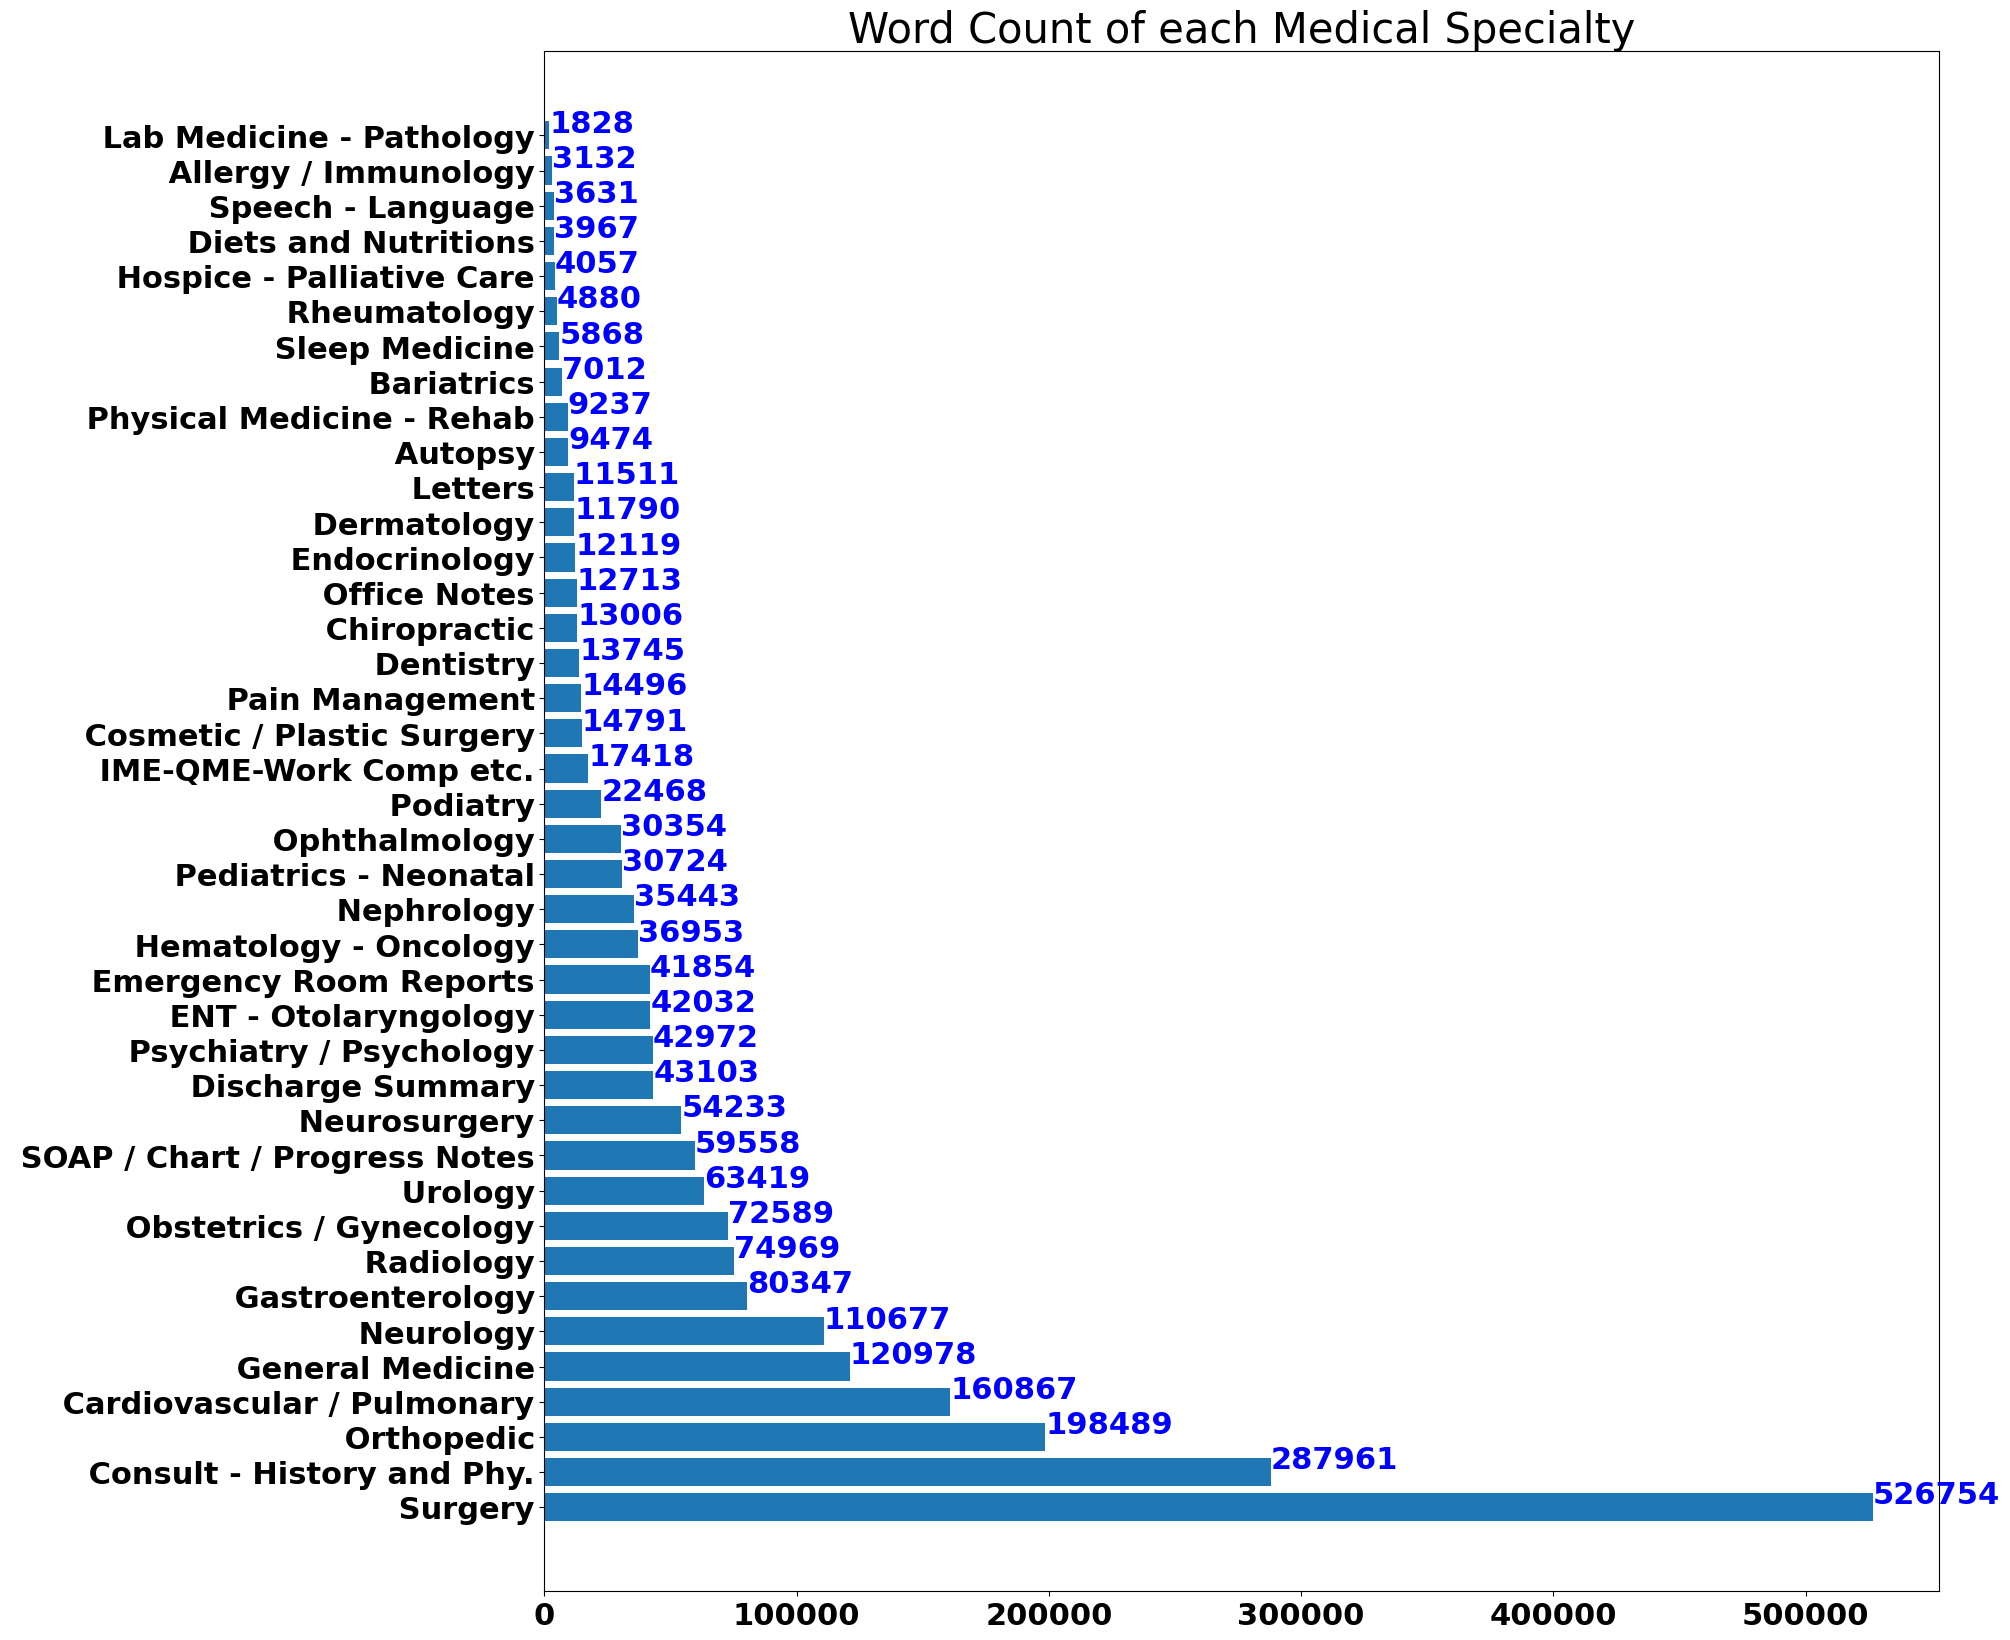

In [9]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


total_word_count = df_medical['transcription'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

bar_plot(word_count_df['Medical Specialty'].values, word_count_df['Word Count'].values,"Word Count of each Medical Specialty")

In [10]:
df_medical = df_medical.loc[:,["transcription", "keywords"]]
df_medical

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4994,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


In [11]:
df_medical.isnull().sum()

transcription      33
keywords         1068
dtype: int64

In [12]:
df_medical = df_medical.dropna(subset=['transcription', 'keywords'])
df_medical.shape

(3898, 2)

In [13]:
df_medical= df_medical.drop_duplicates(['transcription', 'keywords'])
df_medical.shape

(3852, 2)

In [ ]:
transcription = df_medical['transcription'].apply(lambda x: len(x.split()))
transcription

0       204
1       350
2       716
3        68
4       229
       ... 
4984    315
4985    642
4989    273
4993    141
4995    270
Name: transcription, Length: 3852, dtype: int64

Text(0, 0.5, 'Density')

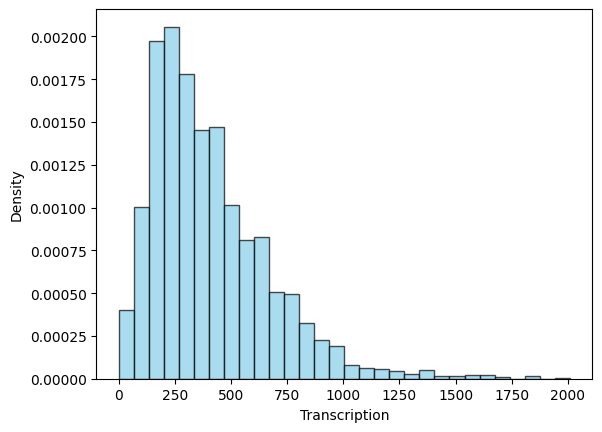

In [ ]:
plt.hist(transcription, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Transcription')
plt.ylabel('Density')
# plt.title('Distribution Plot Example')

In [ ]:
# keywords = pd.DataFrame()
# keywords['count'] = df_medical['keywords'].apply(lambda x: len(x.split()))
# keywords['keywords'] = df_medical['keywords']
keywords = df_medical['keywords'].apply(lambda x: len(x.split()))
keywords

0       15
1       28
2       27
3       29
4       35
        ..
4984    12
4985    32
4989    25
4993    23
4995    13
Name: keywords, Length: 3852, dtype: int64

Text(0, 0.5, 'Density')

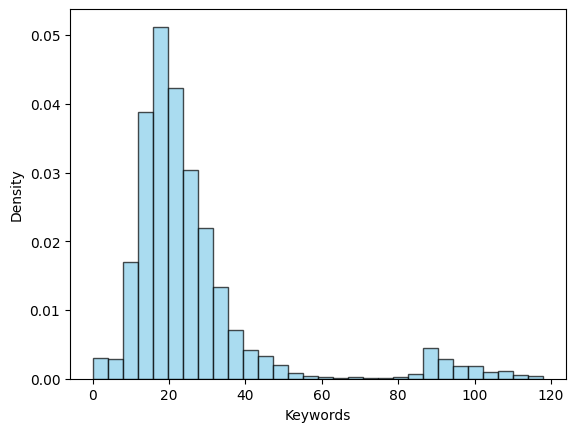

In [ ]:
plt.hist(keywords, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Keywords')
plt.ylabel('Density')

<ipython-input-13-4787efb74e39>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(keywords)


<Axes: xlabel='keywords', ylabel='Density'>

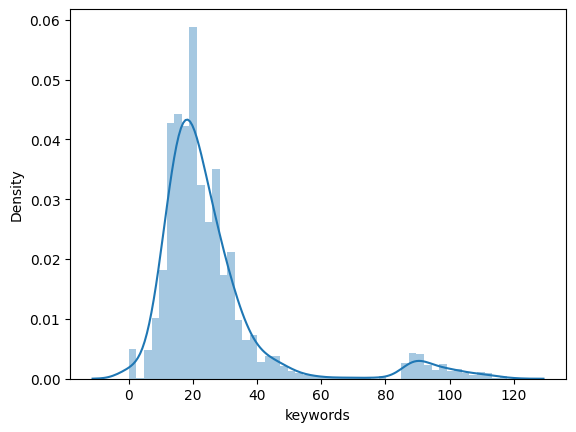

In [ ]:
keywords = df_medical['keywords'].apply(lambda x: len(x.split()))

sns.distplot(keywords)

In [ ]:
df_medical

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4984,"ADMISSION DIAGNOSIS:, Morbid obesity. BMI is...","bariatrics, laparoscopic gastric bypass, gastr..."
4985,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye...","bariatrics, jenny craig, medifast, nutrisystem..."
4989,"PAST MEDICAL HISTORY: ,She had a negative str...","bariatrics, elective surgical weight loss, sur..."
4993,"HISTORY:, A 55-year-old female presents self-...","allergy / immunology, chronic glossitis, xeros..."


### Applying OneVsRestClassifier Machine Learning Algorithm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_medical['transcription'], df_medical['keywords'], test_size=0.2, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3), max_features=50000)
x_train = vectorizer.fit_transform(X_train)
x_test = vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=1e-5, penalty='l1'), n_jobs=-1)

classifier.fit(x_train, y_train)


OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, loss='log',
                                            penalty='l1'),
                    n_jobs=-1)

In [ ]:
predictions = classifier.predict(x_test)

### Calculating Accuracy Using Jaccard Index

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_test_bin = mlb.fit_transform(y_test)
predictions_bin = mlb.transform(predictions)

jaccard_index = jaccard_score(y_test_bin, predictions_bin, average='micro')

# # Step 3: Calculate accuracy as 1 - Jaccard Index
# accuracy = 1 - jaccard_index

print(f'Accuracy using Jaccard Index: {jaccard_index:.4f}')

Accuracy using Jaccard Index: 0.8547


OneVsRestClassifier Accuracy for Word Extraction Task : 85.47

In [ ]:
print(y_test[1])

surgery, open reduction and internal fixation, esmarch, internal fixation, malleolus fracture, lateral malleolus, tourniquet, orif, fixation, ankle, reduction, fracture, malleolus


In [ ]:
print(predictions[1])

orthopedic, open reduction and internal fixation, esmarch, internal fixation, malleolus fracture, lateral malleolus, tourniquet, orif, fixation, ankle, reduction, fracture, malleolus


## Applying Pretrained Facebook-BART model for Keyword Extraction Task

In [22]:
# Using BART

!pip install accelerate bitsandbytes
from transformers import BartForConditionalGeneration, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", padding_side="left",
                                         truncation_side='right')

if torch.cuda.is_available():
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to("cuda")
                                                     # load_in_8bit=True)
else:
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

### BART Model FineTuning Phase

In [23]:
class MedicalKeywordDataset(Dataset):
    def __init__(self, df, transcript, keywords, tokenizer, in_len, out_len):
        self.df = df
        self.transcript = transcript
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.in_len = in_len
        self.out_len = out_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        transcript_tokens = self.tokenizer(self.df[self.transcript].iloc[idx],
                                          padding='max_length',
                                          truncation=True,
                                          max_length=self.in_len,
                                          return_tensors='pt'
                                          )['input_ids']

        keyword_tokens = self.tokenizer(self.df[self.keywords].iloc[idx],
                                       padding="max_length", truncation=True,
                                       max_length=self.out_len,
                                       return_tensors='pt')['input_ids']

        ### Moving the tensors to GPU
        if torch.cuda.is_available():
            transcript_tokens = transcript_tokens.to("cuda")
            keyword_tokens = keyword_tokens.to("cuda")
        return transcript_tokens[0,:], keyword_tokens[0,:]

In [24]:
df_train, df_test = train_test_split(df_medical, train_size=0.9, random_state=34)


ds_train = MedicalKeywordDataset(df_train,'transcription','keywords',tokenizer,
                            750, 100)

ds_test = MedicalKeywordDataset(df_test,'transcription','keywords',tokenizer,
                            750, 100)

batch_size = 6

In [ ]:
### Converting dataset object to dataloader object
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

In [25]:
def num_batches(total, batch_size):
    if total % batch_size == 0:
        return total // batch_size
    else:
        return total // batch_size + 1

In [26]:
optimizer = Adam(model.parameters(),lr=2e-4)

epochs = 3

train_batches = num_batches(df_train.shape[0],batch_size)
test_batches = num_batches(df_test.shape[0],batch_size)

In [29]:
def train(data_loader, num_batches, model, optimizer):
    model.train()
    total_loss = 0
    total_accuracy = 0
    total_batches = len(data_loader)

    with tqdm(total=num_batches, desc="Training", unit="batch") as pbar:
        for i, (inputs, labels) in enumerate(data_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, labels=labels)

            # Loss computation
            loss = outputs.loss
            total_loss += loss.item()

            # Accuracy computation
            logits = outputs.logits
            predictions = torch.argmax(torch.softmax(logits, dim=2), dim=2)
            accuracy = torch.sum(labels == predictions).item() / (labels.shape[0] * labels.shape[1])
            total_accuracy += accuracy

            # Backpropagation
            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix({"loss": total_loss / (i + 1), "accuracy": total_accuracy / (i + 1)})

    pbar.close()

In [30]:
def test(data_loader, num_batches, model):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_batches = len(data_loader)

    with torch.no_grad():  # No need to track gradients during evaluation
        for i, (inputs, labels) in enumerate(tqdm(data_loader, total=total_batches, desc="Testing")):
            # Forward pass
            outputs = model(inputs, labels=labels)

            # Loss computation
            total_loss += outputs.loss.item()

            # Accuracy computation
            logits = outputs.logits
            predictions = torch.argmax(torch.softmax(logits, dim=2), dim=2)
            accuracy = torch.sum(labels == predictions).item() / (labels.shape[0] * labels.shape[1])
            total_accuracy += accuracy

    average_loss = total_loss / total_batches
    average_accuracy = total_accuracy / total_batches

    print(f"Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}")

In [31]:
for e in range(epochs):
    train(dl_train,train_batches,model, optimizer)
    test(dl_test, test_batches,model)

Testing: 100%|██████████| 65/65 [00:16<00:00,  4.02it/s]


Loss: 0.8045, Accuracy: 0.8416


Testing: 100%|██████████| 65/65 [00:16<00:00,  4.04it/s]


Loss: 0.6799, Accuracy: 0.8514


Testing: 100%|██████████| 65/65 [00:16<00:00,  4.06it/s]

Loss: 0.6033, Accuracy: 0.8631


### Comparing the predictions from the test data - BART model

In [36]:
def generate_keywords(df,transcription, model, tokenizer):
    df['Result'] = df[transcription].apply(lambda x: tokenizer(x, max_length=750,
    padding='max_length', truncation=True, return_tensors='pt')['input_ids'])

    if torch.cuda.is_available():
        df['Result'] = df['Result'].apply(lambda x: x.to("cuda"))

    # Generate keywords using the model
    df['Result'] = df['Result'].apply(lambda x: model.generate(x,
                                                    min_length=20,
                                                    max_length=100 ))

    # Decode the generated keyword IDs and add the results to the DataFrame
    df['Result'] = df['Result'].apply(lambda x: tokenizer.batch_decode(x,
                                                    skip_special_tokens=True))
    return df


# def generate_keywords(df, transcription_col, model, tokenizer):
#
#     input_ids = tokenizer(
#         df[transcription_col].tolist(),
#         max_length=750,
#         padding='max_length',
#         truncation=True,
#         return_tensors='pt'
#     )['input_ids']

#     if torch.cuda.is_available():
#         input_ids = input_ids.to("cuda")

#
#     generated_ids = model.generate(
#         input_ids,
#         min_length=20,
#         max_length=100
#     )

#
#     generated_keywords = tokenizer.batch_decode(
#         generated_ids,
#         skip_special_tokens=True
#     )

#
#     df['Result'] = generated_keywords

#     return df

In [37]:
print(torch.cuda.is_available())

True


In [34]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=torch.cuda.current_device()))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2172 MiB |   6322 MiB |  30807 GiB |  30805 GiB |
|       from large pool |   2169 MiB |   6306 MiB |  30600 GiB |  30598 GiB |
|       from small pool |      2 MiB |     15 MiB |    206 GiB |    206 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   2172 MiB |   6322 MiB |  30807 GiB |  30805 GiB |
|       from large pool |   2169 MiB |   6306 MiB |  30600 GiB |

In [38]:
df_res = generate_keywords(df_test,'transcription',model,tokenizer)

In [39]:
df_res['Result'] = df_res['Result'].apply(lambda x: x[0])

In [52]:
# print(df_res.head())
for index, row in df_res.head().iterrows():
    print(f"Row {index + 1}: Transcription = {row['transcription']}")
    print(f"keywords = {row['keywords']}")
    print(f"Predicted Results = {row['Result']}")
    print("*"*100)

Row 2643: Transcription = PREOPERATIVE DIAGNOSES:,1.  Abnormal uterine bleeding.,2.  Status post spontaneous vaginal delivery.,POSTOPERATIVE DIAGNOSES:,1.  Abnormal uterine bleeding.,2.  Status post spontaneous vaginal delivery.,PROCEDURE PERFORMED:,1.  Dilation and curettage (D&C).,2.  Hysteroscopy.,ANESTHESIA: , IV sedation with paracervical block.,ESTIMATED BLOOD LOSS:,  Less than 10 cc.,INDICATIONS:  ,This is a 17-year-old African-American female that presents 7 months status post spontaneous vaginal delivery without complications at that time.  The patient has had abnormal uterine bleeding since her delivery with an ultrasound showing a 6 cm x 6 cm fundal mass suspicious either for retained products or endometrial polyp.,PROCEDURE:,  The patient was consented and seen in the preoperative suite.  She was taken to the operative suite, placed in a dorsal lithotomy position, and placed under IV sedation.  She was prepped and draped in the normal sterile fashion.  Her bladder was drain

## Keyword Extraction Using KeyBERT

In [42]:
pip install keybert

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.8.3-py3-none-any.whl size=39124 sha256=b6b4182cd8cc316aba079a0b0097a98395765e8b2c8c4e110058ba53387f0ea4
  Stored in directory: /root/.cache/pip/wheels/70/88/07/1a3bc11fd1dd5f89924a02dcbca89a3015e25e8faa31f904dc
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=76b26c682fc43e14bab7463dd128a375112c06a01f4bf24bc22267449783a496
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built keybert sentence-transformers


In [43]:
texts = df_medical['transcription'].tolist()

In [44]:
from keybert import KeyBERT

model = KeyBERT()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [46]:
for i, text in enumerate(texts):
    keywords = model.extract_keywords(text, top_n=15)
    print(f"Transcription {i+1}")
    print(df_medical['transcription'][i])
    print("Actual Keywords : ", df_medical['keywords'][i])
    words_only = ', '.join(word for word, _ in keywords)
    print("Model Extracted Keywords : ", words_only)
    print(100*"*")
    if i==10:
      break

Transcription 1
SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple witho